In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt #data-viz
import featuretools as ft
import graphviz
import ipywidgets as widgets
import numpy as np
from sklearn.cluster import KMeans
from sklearn import preprocessing
from kmodes.kmodes import KModes

In [2]:
df = pd.read_csv("SheetPullData.csv")

In [3]:
df.info() # used to check the data types and the null counts in columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12785 entries, 0 to 12784
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HH_ID                 12785 non-null  object 
 1   Roll_ID               12785 non-null  int64  
 2   Roll_Type             12785 non-null  object 
 3   Timestamp             12785 non-null  object 
 4   Time_since_last_pull  12785 non-null  float64
 5   Sheets                12785 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 599.4+ KB


In [4]:
df.describe()

,Roll_ID,Time_since_last_pull,Sheets
count,12785.000000,1.278500e+04,12785.000000
mean,10588.970747,6.551034e+03,4.802993
std,3361.010618,4.400347e+04,3.011595
min,-2557.000000,1.000000e+00,-11.188826
25%,10682.000000,1.100000e+01,2.726480
50%,11758.000000,4.660000e+02,4.654340
75%,12144.000000,7.757000e+03,6.749241
max,13655.000000,4.229427e+06,24.103288


In [5]:
demographic_train =  pd.read_csv("DemographicData.csv")

In [6]:
demographic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   HH_ID           4 non-null      object
 1   HH_Size         4 non-null      int64 
 2   Member1_Age     4 non-null      object
 3   Member1_Gender  4 non-null      object
 4   Member2_Gender  4 non-null      object
dtypes: int64(1), object(4)
memory usage: 288.0+ bytes


### data viz

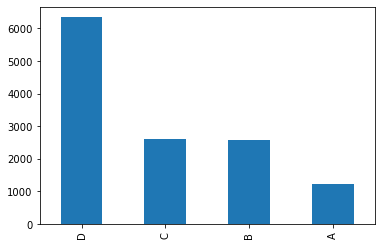

In [7]:
df['HH_ID'].value_counts().plot(kind='bar')

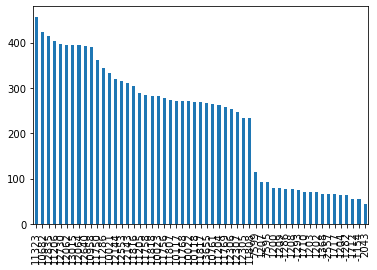

In [8]:
df['Roll_ID'].value_counts().plot(kind='bar') #Roll_ID 4-digit:small, 5-digit:big

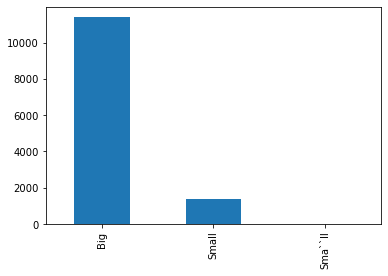

In [9]:
df['Roll_Type'].value_counts().plot(kind='bar');

In [10]:
# 
bins = [0, 10, np.inf]
names = ['<10', '>10']
df['time_range'] = pd.cut(df['Time_since_last_pull'], bins, labels=names)

In [11]:
df['Day of Week'] = pd.to_datetime(df['Timestamp']).dt.day_name() #dayofweek day_name() weekday
df['weekday'] = pd.to_datetime(df['Timestamp']).dt.weekday

In [12]:
df['hour'] = pd.to_datetime(df['Timestamp']).dt.hour 

In [13]:
b = [0,4,8,12,16,20,24]
l = ['Late Night', 'Early Morning','Morning','Noon','Eve','Night']
df['session'] = pd.cut(df['hour'], bins=b, labels=l, include_lowest=True)

In [14]:
# add flag column weekday or weekend (Fri 1800 ~ Mon 0300) 
def flag_df(df):

    if  df['weekday'] in [5,6]:
        return 'weekend'
    elif ((df['weekday'] == 0) and (df['hour'] <= 3)) or ((df['weekday'] == 4) and (df['hour'] >= 18)):
        return 'weekend'
    else: 
        return 'weekday'

df['flag'] = df.apply(flag_df, axis = 1)

In [15]:
# resort by ID and timestamp
df = df.sort_values(['HH_ID','Timestamp'])

In [16]:
# add events column
events_count = []
count = 0
for row in df['Time_since_last_pull']:
    if(row  > 10.0):
        count +=1
    events_count.append(count)
df['event'] = events_count

In [17]:
# group by event and sum the value by same event
group_result = df.groupby('event').agg({'HH_ID':min, 'Roll_ID':min, 'Roll_Type':'first', 
                                        'Timestamp':min, 'Time_since_last_pull':'first',
                                        'Sheets':sum, 'time_range':'last', 'Day of Week':'first', 'weekday': 'first', 'hour':min, 'session':'first', 'flag':'first'})

In [18]:
group_result.groupby(['HH_ID' , 'time_range'])['Sheets'].mean()

HH_ID  time_range
A      <10            7.412601
       >10            4.874226
B      <10            5.496279
       >10            4.505743
C      <10            8.712004
       >10            4.576608
D      <10           13.901290
       >10            5.246688
Name: Sheets, dtype: float64

In [19]:
pd.set_option("display.max_rows", 10, "display.max_columns", None)

In [20]:
splits = list(group_result.groupby("HH_ID")) 
dfa = splits[0][1]
dfb = splits[1][1]
dfc = splits[2][1]
dfd = splits[3][1]

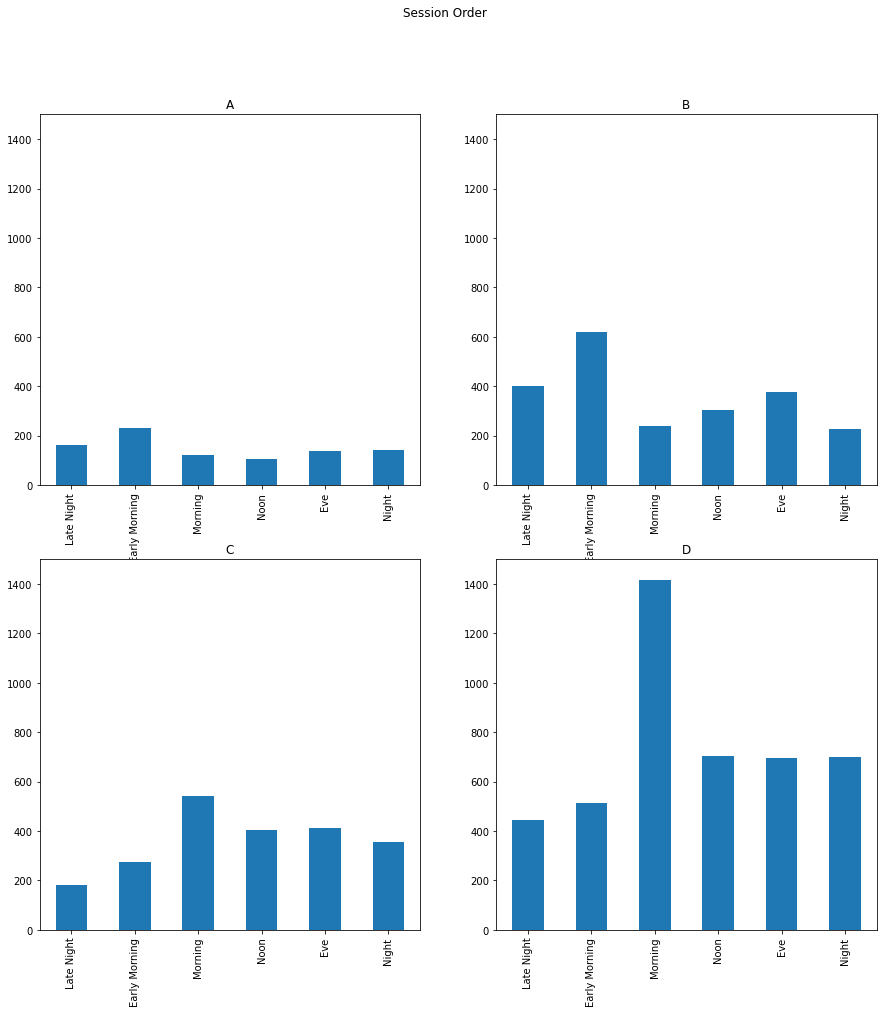

In [21]:
session_order = ['Late Night', 'Early Morning','Morning','Noon','Eve','Night']
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,15))
fig.suptitle('Session Order')
axes[0][0].set_title('A')
axes[0][1].set_title('B')
axes[1][0].set_title('C')
axes[1][1].set_title('D')
dfa['session'].value_counts().loc[session_order].plot(ax=axes[0,0],kind='bar', ylim = (0,1500))
dfb['session'].value_counts().loc[session_order].plot(ax=axes[0,1],kind='bar', ylim = (0,1500))
dfc['session'].value_counts().loc[session_order].plot(ax=axes[1,0],kind='bar', ylim =(0,1500))
dfd['session'].value_counts().loc[session_order].plot(ax=axes[1,1],kind='bar', ylim = (0,1500))

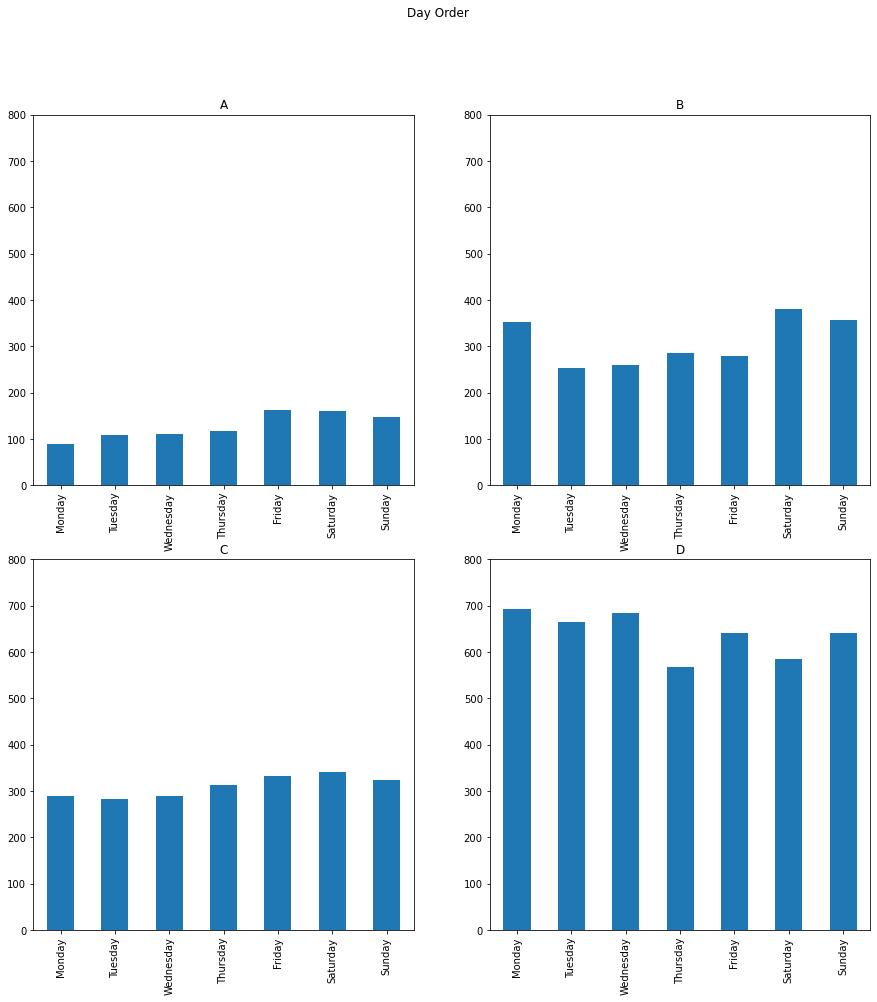

In [22]:
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,15))
fig.suptitle('Day Order')
axes[0][0].set_title('A')
axes[0][1].set_title('B')
axes[1][0].set_title('C')
axes[1][1].set_title('D')
dfa['Day of Week'].value_counts().loc[day_order].plot(ax=axes[0,0],kind='bar', ylim = (0,800) )
dfb['Day of Week'].value_counts().loc[day_order].plot(ax=axes[0,1],kind='bar', ylim = (0,800) )
dfc['Day of Week'].value_counts().loc[day_order].plot(ax=axes[1,0],kind='bar', ylim = (0,800) )
dfd['Day of Week'].value_counts().loc[day_order].plot(ax=axes[1,1],kind='bar', ylim = (0,800) )

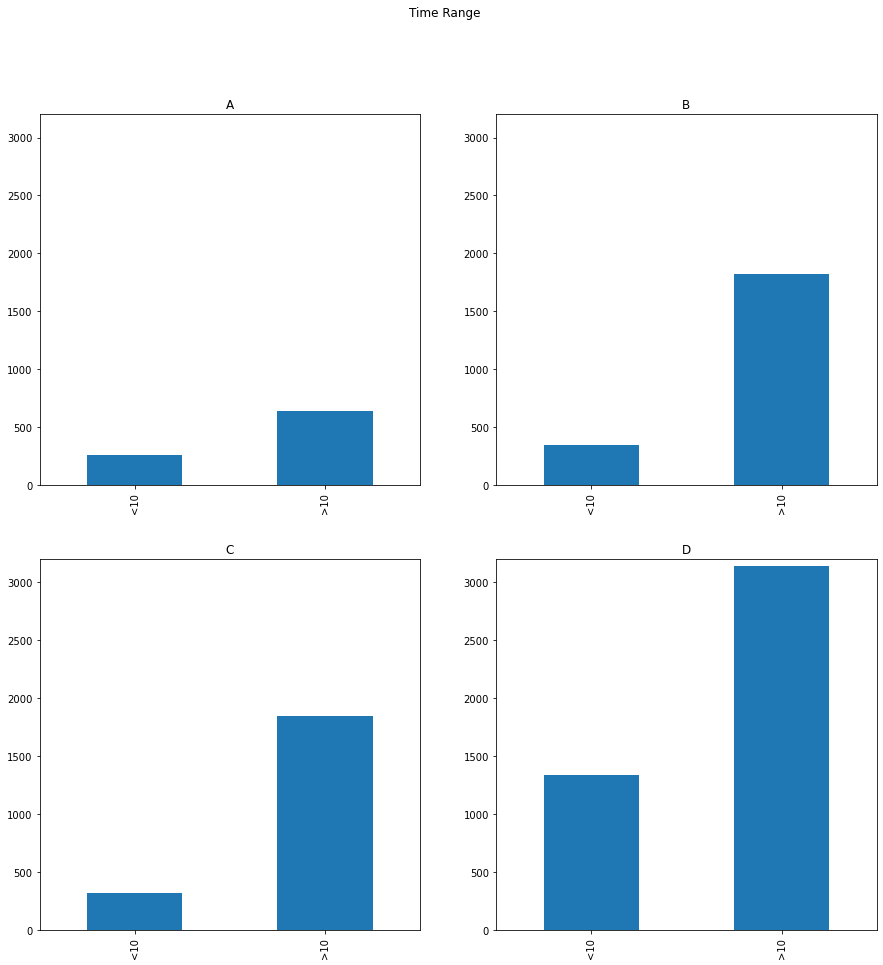

In [23]:
timerange = ['<10', '>10']
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,15))
fig.suptitle('Time Range')
axes[0][0].set_title('A')
axes[0][1].set_title('B')
axes[1][0].set_title('C')
axes[1][1].set_title('D')
dfa['time_range'].value_counts().loc[timerange].plot(ax=axes[0,0],kind='bar', ylim = (0,3200) )
dfb['time_range'].value_counts().loc[timerange].plot(ax=axes[0,1],kind='bar', ylim = (0,3200) )
dfc['time_range'].value_counts().loc[timerange].plot(ax=axes[1,0],kind='bar', ylim = (0,3200) )
dfd['time_range'].value_counts().loc[timerange].plot(ax=axes[1,1],kind='bar', ylim = (0,3200) )

### check Group D's period feature

In [24]:
# period task
testD = group_result
testD = testD.loc[testD['HH_ID'] == 'D'] 
testD['day'] = pd.to_datetime(testD.Timestamp).dt.day
testD['month'] = pd.to_datetime(testD.Timestamp).dt.month
testD['year'] = pd.to_datetime(testD.Timestamp).dt.year

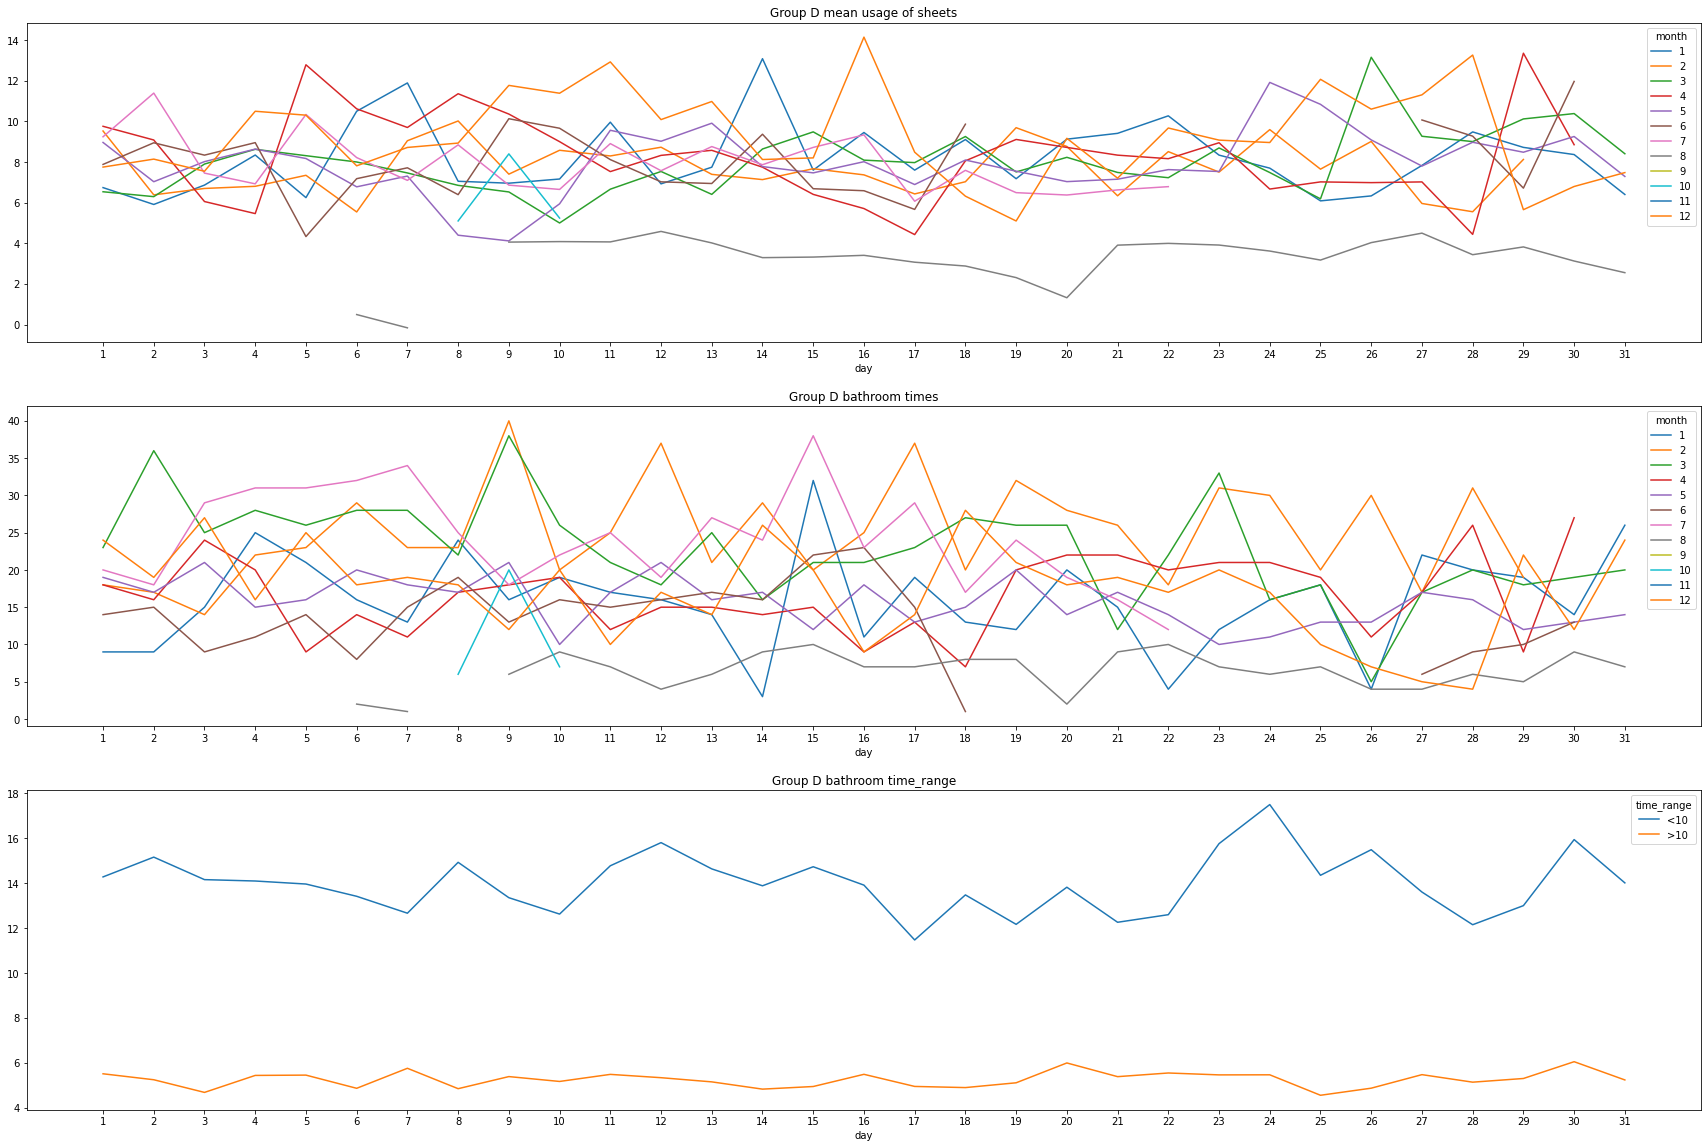

In [25]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(30,20))

# Specify how our lines should look
#ax.plot(testDJan.day, testDJan.Sheets, color='tab:orange')

ax[0].set_xticks(testD['day'].unique())
ax[1].set_xticks(testD['day'].unique())
ax[2].set_xticks(testD['day'].unique())
ax[0].set_title('Group D mean usage of sheets')
ax[1].set_title('Group D bathroom times')
ax[2].set_title('Group D bathroom time_range')

# D group number of sheets mean by month and day
testD.groupby(["day", "month"]).mean()['Sheets'].unstack().plot(ax=ax[0])

# D group number of times by month and day
testD.groupby(["day", "month"]).count()['Sheets'].unstack().plot(ax=ax[1])

# D group bathroom time_range
testD.groupby(["day", "time_range"]).mean()['Sheets'].unstack().plot(ax=ax[2])

In [26]:
group_result.groupby(['HH_ID' , 'time_range'])['Sheets'].mean()

HH_ID  time_range
A      <10            7.412601
       >10            4.874226
B      <10            5.496279
       >10            4.505743
C      <10            8.712004
       >10            4.576608
D      <10           13.901290
       >10            5.246688
Name: Sheets, dtype: float64

In [27]:
group_result.groupby('HH_ID')['Sheets'].mean()

HH_ID
A    5.607975
B    4.664503
C    5.188342
D    7.826630
Name: Sheets, dtype: float64

In [28]:
group_result['Sheets'].mean()

6.326629471397517

In [29]:
Roll_Type_dic = {'Big':0, 'Small':1}
time_range_dic = {'<10': 0, '>10': 1}
weekday_dic={'weekday':0,'weekend':1}
group_result['Roll_Type'] = group_result['Roll_Type'].replace(Roll_Type_dic, regex=True)
group_result['flag'] = group_result['flag'].replace(weekday_dic, regex=True)
group_result['time_range'] = group_result['time_range'].replace(time_range_dic, regex=True)
group_result.loc[:, 'weekday'] += 1

### k-means

In [30]:
# segmentation by weekday(flag) and sheets
X1 = group_result[['time_range' , 'Sheets']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='full') )
    algorithm.fit(X1)
    inertia.append(algorithm.inertia_)

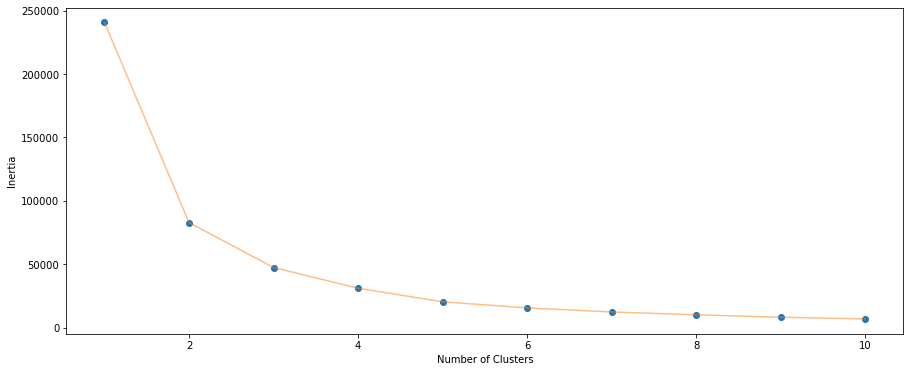

In [31]:
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

In [32]:
algorithm = (KMeans(n_clusters = 4 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X1)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

In [33]:
h = 0.02
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()]) 

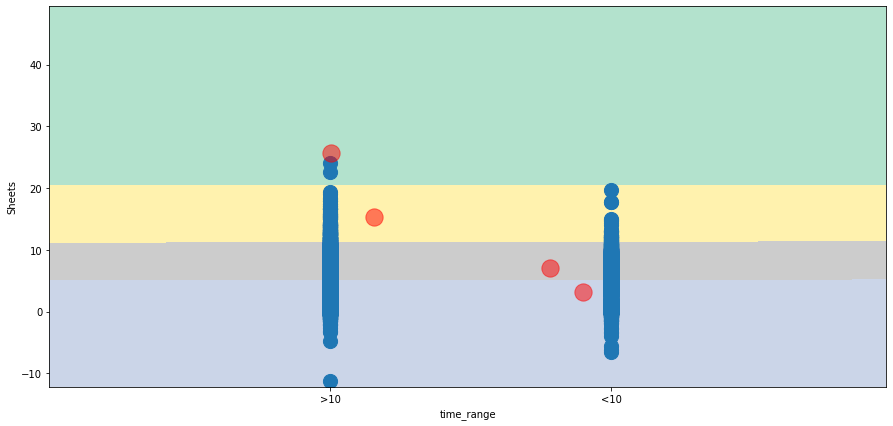

In [34]:
plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z = Z.reshape(xx.shape)
plt.imshow(Z , interpolation='nearest', 
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x = 'time_range' ,y = 'Sheets' , data = df , 
            s = 200 )
plt.scatter(x = centroids1[: , 0] , y =  centroids1[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('Sheets') , plt.xlabel('time_range')
plt.show()

### k-modes

In [35]:
group_result_copy = group_result.copy()

In [36]:
group_result_copy.loc[group_result_copy['Time_since_last_pull'] >=180 , 'Time_since_last_pull'] = 180

In [37]:
le = preprocessing.LabelEncoder()
group_result_copy = group_result_copy.apply(le.fit_transform)
group_result_copy.head()

,HH_ID,Roll_ID,Roll_Type,Timestamp,Time_since_last_pull,Sheets,time_range,Day of Week,weekday,hour,session,flag
event,,,,,,,,,,,,
1,0,9,1,25,164,6638,0,2,5,16,5,1
2,0,9,1,26,113,2618,1,2,5,16,5,1
3,0,9,1,27,164,2184,1,2,5,16,5,1
4,0,9,1,28,164,1320,1,2,5,16,5,1
5,0,9,1,30,164,6882,1,2,5,19,1,1


In [38]:
# Using K-Mode with "Cao" initialization
km_cao = KModes(n_clusters=2, init = "Cao", n_init = 1, verbose=1)
fitClusters_cao = km_cao.fit_predict(group_result_copy)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 54, cost: 70337.0


In [40]:
clusterCentroidsDf = pd.DataFrame(km_cao.cluster_centroids_)
clusterCentroidsDf.columns = group_result_copy.columns

In [41]:
clusterCentroidsDf

,HH_ID,Roll_ID,Roll_Type,Timestamp,Time_since_last_pull,Sheets,time_range,Day of Week,weekday,hour,session,flag
0,3,52,0,3447,164,5450,1,1,0,11,3,0
1,1,31,0,2,164,3170,1,2,5,6,0,1


In [42]:
# Using K-Mode with "Huang" initialization
km_huang = KModes(n_clusters=2, init = "Huang", n_init = 1, verbose=1)
fitClusters_huang = km_huang.fit_predict(group_result_copy)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2034, cost: 70278.0
Run 1, iteration: 2/100, moves: 575, cost: 70226.0
Run 1, iteration: 3/100, moves: 50, cost: 70226.0


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 76549.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 54, cost: 70337.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 66901.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 64601.0


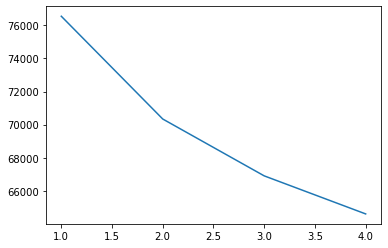

In [44]:
# Choosing K by comparing Cost against each K
cost = []
for num_clusters in list(range(1,5)):
    kmode = KModes(n_clusters=num_clusters, init = "Cao", n_init = 1, verbose=1)
    kmode.fit_predict(group_result_copy)
    cost.append(kmode.cost_)
y = np.array([i for i in range(1,5,1)])
plt.plot(y,cost)

In [45]:
km_cao = KModes(n_clusters=2, init = "Cao", n_init = 1, verbose=1)
fitClusters_cao = km_cao.fit_predict(group_result_copy)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 54, cost: 70337.0


In [47]:
group_result_copy = group_result.reset_index()

In [48]:
clustersDf = pd.DataFrame(fitClusters_cao)
clustersDf.columns = ['cluster_predicted']
combinedDf = pd.concat([group_result_copy, clustersDf], axis = 1).reset_index()
combinedDf = combinedDf.drop(['index', 'hour'], axis = 1)

In [50]:
cluster_0 = combinedDf[combinedDf['cluster_predicted'] == 0]
cluster_1 = combinedDf[combinedDf['cluster_predicted'] == 1]
cluster_2 = combinedDf[combinedDf['cluster_predicted'] == 2]
cluster_3 = combinedDf[combinedDf['cluster_predicted'] == 3]

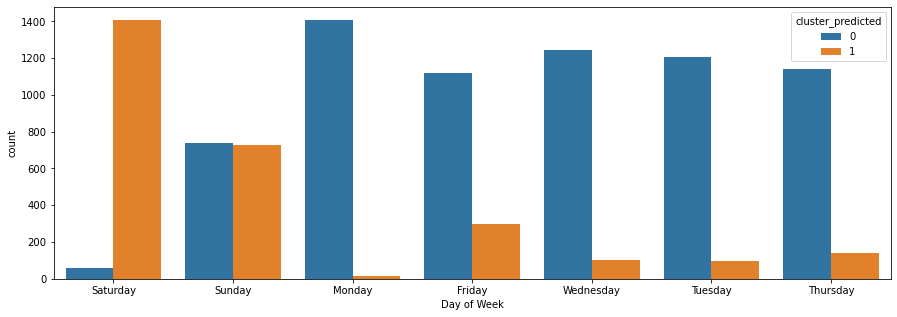

In [51]:
plt.subplots(figsize = (15,5))
sns.countplot(x=combinedDf['Day of Week'],order=combinedDf['Day of Week'].value_counts().index,hue=combinedDf['cluster_predicted'])
plt.show()

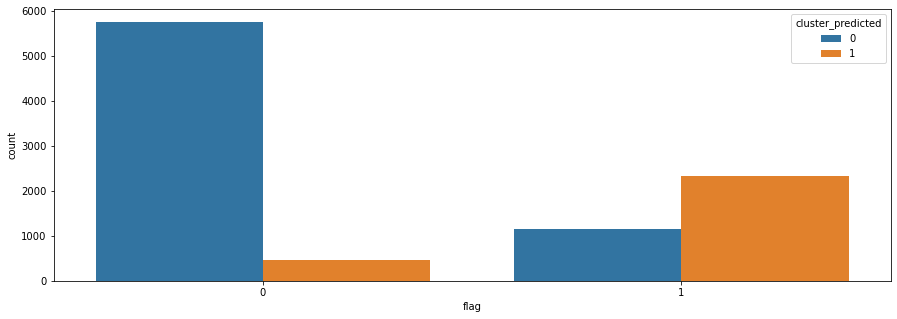

In [52]:
plt.subplots(figsize = (15,5))
sns.countplot(x=combinedDf['flag'],order=combinedDf['flag'].value_counts().index,hue=combinedDf['cluster_predicted'])
plt.show()

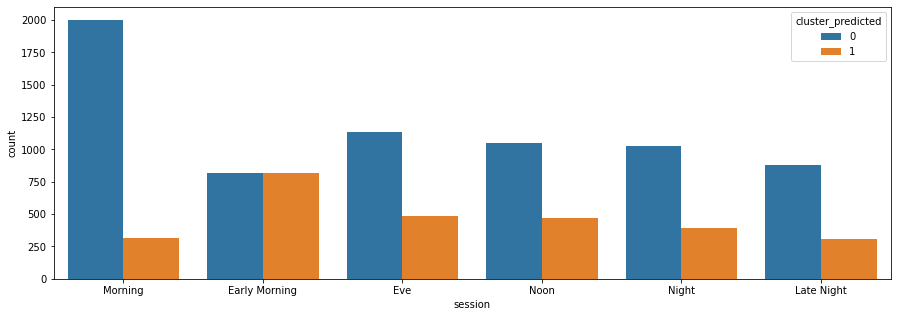

In [53]:
plt.subplots(figsize = (15,5))
sns.countplot(x=combinedDf['session'],order=combinedDf['session'].value_counts().index,hue=combinedDf['cluster_predicted'])
plt.show()

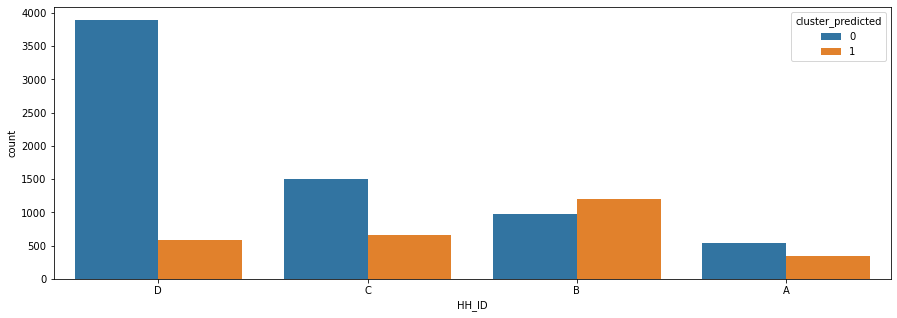

In [56]:
plt.subplots(figsize = (15,5))
sns.countplot(x=combinedDf['HH_ID'],order=combinedDf['HH_ID'].value_counts().index,hue=combinedDf['cluster_predicted'])
plt.show()

Text(0, 0.5, 'Mean')

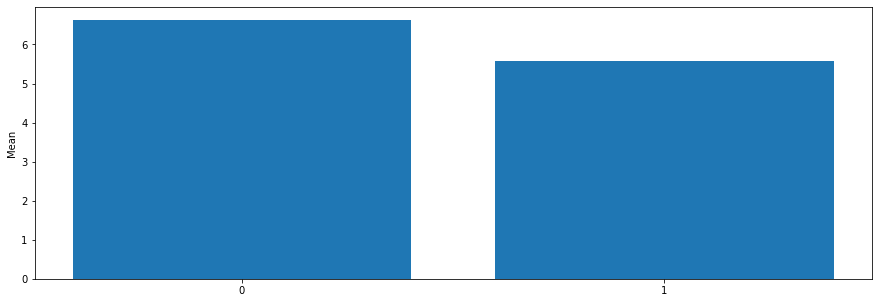

In [55]:
plt.subplots(figsize = (15,5))
combinedDf1 = combinedDf.groupby('cluster_predicted').mean().reset_index()
plt.bar(range(len(combinedDf1)), combinedDf1['Sheets'])
plt.xticks(range(len(combinedDf1)), combinedDf1['cluster_predicted'])
plt.ylabel('Mean')